# SIRQH: Quantifying Happiness
*** Skye Ozga and Sam Daitzman ***

In this model, we ask whether implementing a quarantine at Olin to slow the freshman plague would increase or decrease student happiness. We built a standard SIR model for Olin, added a variable-efficiency quarantine model that kicks in after a particular number of infections, and swept the aggressiveness of the quarantine. Our output metric is the integral of happiness at Olin, which represents normalized total happiness over the fall semester.

## Quantifying Relative Happiness
To quantify relative happiness, we sent a survey to a popular mailing list at Olin offering brownies for data. We collected 96 responses on baseline happiness, happiness when alone for prolonged time, happiness when sick, contacts per day when healthy, contacts per day when sick, and days sick during Olin's freshman plague (if infected). The happiness responses are all between 1 and 10.

## Survey Response Data

| Datum | Mean Response | Standard Deviation |Possible Range*||
|-|-|-|-|
| Happiness (typical) | 6.828 | 1.761 |1...10|
| Happiness (prolonged loneliness)|5.290|2.348|1...10|
|Happiness (sick)|3.204|1.441|1...10|
|Contacts per Day (healthy)|25.880|19.396|0...Infinity|
|Contacts per Day (sick)|7.185|5.773|0...Hopefully not too many|

\* This is NOT the response range. This is the range the values could have.

## Modeling Approach
We laid out an iterative modeling approach at the beginning of the project to guide our process.

### Step 1: Build SIR Model for Olin
Build a basic SIR model for the Olin freshman plague. Use survey results as constraints:
- Contact Rate
- Recovery Speed
- Infection Rate
    
    
### Step 2: Add Quarantine
Add a quarantine stock and flows in and out.
- Keep a working version without Quarrantine
- I -> Q -> R
- Can only infect roommate when quarantined, with 1 interaction per day


### Step 3: Create Happiness
Convert our survey data to a useful representation of typical happiness when sick vs. alone vs. sick-and-alone.
- Assign baseline happiness
- Calculate loneliness and sickness modifiers
    

### Step 4: Integrate Happiness
Add happiness to the simulation, calculated during each run of the slope/update function.
- Being sick = less happy
- Being alone = less happy
- Being sick and alone = loneliness modifier * sickness modifier * typical happiness
- Integrate the happiness curve and divide by time; the result (average happiness) is our metric for that run.
    
    
### Step 5: Add Quarantine Aggressiveness Parameters
Add parameters that represent how strong the quarantine will be.
- Quarantine efficiency
- Infection threshold to begin quarantine program


### Step 6: Sweep Quarantine Aggressiveness
Experiment with sweeping different parameters to decide which is most useful to maximize happiness
- Multiple Line plots ranging from no quarantine to lots of quarantine

## Libraries and Setup

In [0]:
#import all the libraries
from modsim import *
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr'

## Model Parameters

In [0]:
T_0    = 0.0

# First semester is 111 days spent at olin
T_END  = 111.0

# 1 hour  timestep
dt     = 1/(24*1)

# F. W. Olin College of Engineering
pop    = 380.0

# Assume symptoms appear after 3 days; days sick = reported value + 3
t_sick = 7.185 + 3

# Quarantine Rate 
# Assume Symptoms take 3 days to apear 
# and students are quarantined 2 days after symptoms appear
# so, quarantine is effective starting after 5 days
# percentage of time spent sick to be eligible for quarantine
pi = (t_sick-5)/t_sick

# Quarantine effectiveness
# proportion of studens that are caught by quarantine
mu = 0.8

# Quarantine Constant
# Actual rate at which students are effectively quarantined
alpha = mu * pi

# Contact Rate
# Beta value selected so that total infected matches reported value
beta  = 0.1618869

# Recovery Rate = 1/Days Sick
gamma = 1/t_sick

# Quarantined Recovery Rate
# Students ride out the rest of their illness stuck in their room
# Again assume 
delta = 1/(t_sick-5)

# Quarantined infectivity rate
# Students can only infect their roommate
# potentially use this as a method of sweeping quarrantine effectiveness
epsilon = 1/pop

# Quarantine threshold
# Proportion of population that needs to be sick 
# for people to start getting quarantined
threshold = 0.05 * pop

## Modeling Setup

In [0]:
def make_system(beta, gamma):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=pop-1, I=1, R=0)

    return System(init=init, t_0=T_0, t_end=T_END,
                  beta=beta, gamma=gamma)

In [0]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.row[t_0] = init
    
    for t in linrange(t_0, t_end):
        frame.row[t+1] = update_func(frame.row[t], t, system)
    
    return frame

In [0]:
def plot_SIR(frame):
    """Plot the results of a SIR model.
    
    S: TimeSeries
    I: TimeSeries
    R: TimeSeries
    """
    
    plot(frame.S, '--', label='Susceptible')
    plot(frame.I, '-', label='Infected')
    plot(frame.R, ':', label='Recovered')
    decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

In [0]:
def update_func(state, t, system):
    """Update the SIR model.
    
    state: State (s, i, r)
    t: time
    system: System object
    
    returns: State (sir)
    """
    s, i, r = state

    for n in range (int(1/dt)):
        infected = system.beta * i * s
        recovered = system.gamma * i
    
        s -= infected
        i += infected - recovered
        r += recovered
    
    return State(S=s, I=i, R=r)

In [0]:
def slope_SIR(state, t, system):
    """Update the SIR model.
    
    state: State (s, i, r)
    t: time
    system: System object
    
    returns: State (sir)
    """
    s, i, r = state

    dSdt = -system.beta * i * s / pop
    dIdt = system.beta * i * s / pop- system.gamma * i
    dRdt = system.gamma * i

    
    return dSdt, dIdt, dRdt

In [0]:
def calc_total_infected(results):
    """Fraction of population infected during the simulation.
    
    results: DataFrame with columns S, I, R
    
    returns: fraction of population
    """
    return get_first_value(results.S) - get_last_value(results.S)

# 

## Basic SIR Model

221.0928624200031

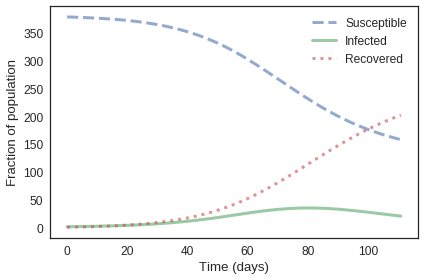

In [9]:
sir = make_system(beta, gamma)
results, details = run_ode_solver(sir, 
                                  slope_SIR, 
                                  t_eval = linrange(sir.t_0, sir.t_end, dt)
                                 )

plot_SIR(results)
#print(results.head)
#details
calc_total_infected(results)

## Adding a Quarantine

In [0]:
def make_system_Qb(alpha, beta, gamma, delta, epsilon, threshold):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=pop-1, I=1, R=0, Q=0)

    return System(init=init, t_0=T_0, t_end=T_END, threshold=threshold, a=alpha,
                  alpha=0, beta=beta, gamma=gamma, delta=delta, epsilon=epsilon)

In [0]:
def slope_SIRQb(state, t, system):
    """Update the SIR model.
    
    state: State (s, i, r)
    t: time
    system: System object
    
    returns: State (sir)
    """
    s, i, r, q = state
    
    dSdt = -system.beta * i * s / pop - system.epsilon * q * s / pop
    dIdt = system.beta * i * s / pop + system.epsilon * q * s / pop - system.gamma * i - system.alpha * i
    dRdt = system.gamma * i + system.delta * q
    dQdt = system.alpha * i - system.delta * q

    
    if(i > 30 and system.alpha == 0):
      #print(system.alpha)
      system.alpha = system.a
      #print('yeet')
      #print(system.alpha)

    return dSdt, dIdt, dRdt, dQdt

In [0]:
def update_SIRQb(state, t, system):
    """Update the SIR model.
    
    state: State (s, i, r)
    t: time
    system: System object
    
    returns: State (sir)
    """
    s, i, r, q = state
    for n in range (int(1/dt)):
      dSdt = (-system.beta * i * s / pop - system.epsilon * q * s / pop) * dt
      dIdt = (system.beta * i * s / pop + system.epsilon * q * s / pop - system.gamma * i - system.alpha * i) * dt
      dRdt = (system.gamma * i + system.delta * q) * dt
      dQdt = (system.alpha * i - system.delta * q) * dt

      if(i > 30 and system.alpha == 0):
        #print(system.alpha)
        system.alpha = system.a
        #print('yeet')
        #print(system.alpha)
      
      s += dSdt
      i += dIdt
      r += dRdt
      q += dQdt

    return State(S=s, I=i, R=r, Q=q)

In [0]:
def run_simulationQb(system, update_func):
    frame = TimeFrame(columns=system.init.index)
    frame.row[system.t_0] = system.init
    
    for t in linrange(system.t_0, system.t_end):
      frame.row[t+1] = update_func(frame.row[t], t, system)
      
    return(frame)

107 total infections in our simulation.


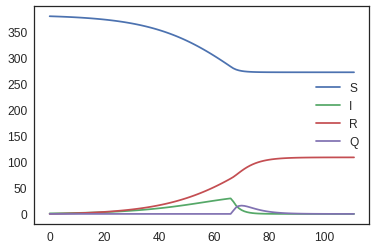

In [14]:
sirq = make_system_Qb(alpha, beta, gamma, delta, epsilon, threshold)
results = run_simulationQb(sirq, update_SIRQb)
results.plot()
#details
print(str(int(round(calc_total_infected(results)))) + " total infections in our simulation.")

98 total infections according to the ordinary differential equation solver.


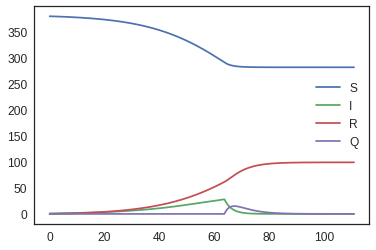

In [15]:
sirq = make_system_Qb(alpha, beta, gamma, delta, epsilon, threshold)
results, details = run_ode_solver(sirq, slope_SIRQb, 
                              t_eval = linrange(sirq.t_0, sirq.t_end, dt),
                              method = 'LSODA')

results.plot()
#details
print(str(int(round(calc_total_infected(results)))) + " total infections according to the ordinary differential equation solver.")

The ODE solver finds a slightly different result, but they're relatively close. We chose the LSODA ODE solver because it automatically chooses between nonstiff (Adams) and stiff (BDF) solver methods as it goes, so it handles the kink when the quarantine kicks in relatively well.

## Happiness Levels

In [16]:
# Happiness data comse from survey of about 90 Olin students
# and is rated on your classic scale from 1 to 10

# Baseline happiness when neither sick nor alone
h0 = 6.828 / 10.0

# Sick Happiness
hi = 3.204 / 10.0

# Alone Happiness
ha = 5.209 / 10.0

# Quarantined happiness
# you are sick and alone. Feels bad.
hq = ha * hi / h0

print(hq)

0.2444293497363796


## Quantifying Happiness

In [0]:
def make_system_QH(alpha, beta, gamma, delta, epsilon, threshold):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=pop-1, I=1, R=0, Q=0)
    
    hf = TimeSeries()
    hf[0] = h0*pop

    return System(init=init, t_0=T_0, t_end=T_END, threshold=threshold, a=alpha,
                  alpha=0, beta=beta, gamma=gamma, delta=delta, epsilon=epsilon,
                  happiness = 0, happy_fun=hf)

In [0]:
def slope_SIRQH(state, t, system):
    """Update the SIR model.
    
    state: State (s, i, r)
    t: time
    system: System object
    
    returns: State (sir)
    """
    s, i, r, q = state
    
    dSdt = -system.beta * i * s / pop - system.epsilon * q * s / pop
    dIdt = system.beta * i * s / pop + system.epsilon * q * s / pop - system.gamma * i - system.alpha * i
    dRdt = system.gamma * i + system.delta * q
    dQdt = system.alpha * i - system.delta * q
 
    h = (s+r)*h0 + i*hi + q * hq
    
    system.happiness += h
    
    if t==0 or t > get_last_label(system.happy_fun):
      system.happy_fun[t] = h / pop * 10
    
    if(i > system.threshold and system.alpha == 0):
      #print(system.alpha)
      system.alpha = system.a
      #print('yeet')
      #print(system.alpha)

    return dSdt, dIdt, dRdt, dQdt

In [0]:
def update_SIRQH(state, t, system):
    """Update the SIR model.
    
    state: State (s, i, r)
    t: time
    system: System object
    
    returns: State (sir)
    """
    s, i, r, q = state
    for n in range (int(1/dt)):
      dSdt = (-system.beta * i * s / pop - system.epsilon * q * s / pop) * dt
      dIdt = (system.beta * i * s / pop + system.epsilon * q * s / pop - system.gamma * i - system.alpha * i) * dt
      dRdt = (system.gamma * i + system.delta * q) * dt
      dQdt = (system.alpha * i - system.delta * q) * dt
      
      
      h = (s+r)*h0 + i*hi + q * hq
    
      system.happiness += h * dt / system.t_end / pop * 10.0
      
      system.happy_fun[t + n*dt] = h / pop * 10.0

      if(i > system.threshold and system.alpha == 0):
        #print(system.alpha)
        system.alpha = system.a
        #print('yeet')
        #print(system.alpha)
      '''  
      if(i < system.threshold and system.alpha == system.a):
        #print(system.alpha)
        system.alpha = 0
        #print('yeet')
        #print(system.alpha)
      '''
      s += dSdt
      i += dIdt
      r += dRdt
      q += dQdt

    return State(S=s, I=i, R=r, Q=q)

In [0]:
def plot_SIRQ(frame):
    """Plot the results of a SIR model.
    
    S: TimeSeries
    I: TimeSeries
    R: TimeSeries
    Q: TimeSeries
    """

    
    plot(frame.S, '-', label='Susceptible')
    plot(frame.I, '-', label='Infected')
    plot(frame.R, ':', label='Recovered')
    plot(frame.Q, '-', label='Quarantined')
    decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

58 total infections according to the ordinary differential equation solver.


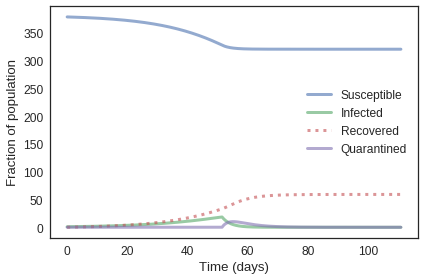

In [21]:
sirq = make_system_QH(alpha, beta, gamma, delta, epsilon, threshold)
results, details = run_ode_solver(sirq, slope_SIRQH, 
                              t_eval = linrange(sirq.t_0, sirq.t_end, dt),
                              method = 'LSODA')

plot_SIRQ(results)
print(str(int(round(calc_total_infected(results)))) + " total infections according to the ordinary differential equation solver.")

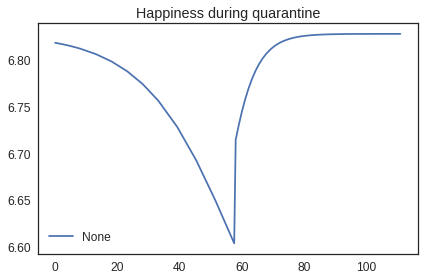

In [22]:
sirq.happy_fun.plot()
decorate(title="Happiness during quarantine", legend="None")

## Sweeping Happiness

In [27]:
thresholds = []
for n in range (11):
  thresholds.append(n*5)
print(thresholds)

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]


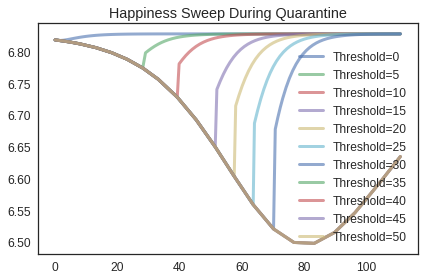

In [24]:
for x in thresholds:
  sirq = make_system_QH(alpha, beta, gamma, delta, epsilon, x)
  results, details = run_ode_solver(sirq, slope_SIRQH, 
                              t_eval = linrange(sirq.t_0, sirq.t_end, dt),
                              method = 'LSODA')
  plot(sirq.happy_fun, label = ("Threshold=" + str(x)))
  decorate(title="Happiness Sweep During Quarantine")

0 sick people before beginning quarantine: average happiness=6.827092035810656
1 sick people before beginning quarantine: average happiness=6.827086070843095
2 sick people before beginning quarantine: average happiness=6.824812479517566
3 sick people before beginning quarantine: average happiness=6.822519535433464
4 sick people before beginning quarantine: average happiness=6.820211797457602
5 sick people before beginning quarantine: average happiness=6.817887785997418
6 sick people before beginning quarantine: average happiness=6.815542584101227
7 sick people before beginning quarantine: average happiness=6.813163133897045
8 sick people before beginning quarantine: average happiness=6.810779554530391
9 sick people before beginning quarantine: average happiness=6.808339855250243
10 sick people before beginning quarantine: average happiness=6.805900381745257
11 sick people before beginning quarantine: average happiness=6.803402506307549
12 sick people before beginning quarantine: averag

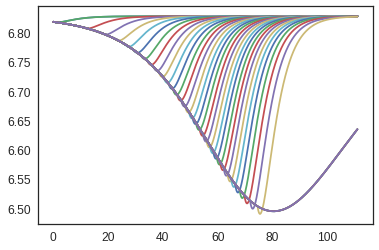

In [25]:
thresholds = linrange(0,40)
for x in thresholds:
  sirq = make_system_QH(alpha, beta, gamma, delta, epsilon, x)
  results = run_simulationQb(sirq, update_SIRQH)
  print(str(x) + " sick people before beginning quarantine: average happiness=" + str(sirq.happiness))
  sirq.happy_fun.plot()


## Abstract
We found that Olin would be significantly happier during first semester, on average, if we implemented a reactive quarantine program that kicks in at a particular number of infected students. The plot below shows happiness over time at various quarantine thresholds. The lower the quarantine threshold, the happier people are on average (and at the least happy point in the semester). In the plot below, we see a range of possible quarantine thresholds plotted against happiness.

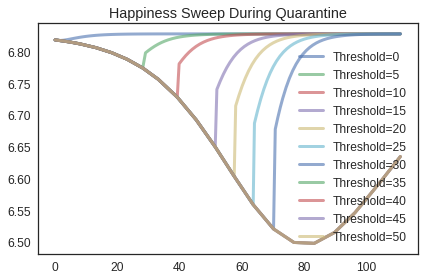

In [28]:
for x in thresholds:
  sirq = make_system_QH(alpha, beta, gamma, delta, epsilon, x)
  results, details = run_ode_solver(sirq, slope_SIRQH, 
                              t_eval = linrange(sirq.t_0, sirq.t_end, dt),
                              method = 'LSODA')
  plot(sirq.happy_fun, label = ("Threshold=" + str(x)))
  decorate(title="Happiness Sweep During Quarantine")

# ModSimPy <3 Colaboratory
To configure this notebook and Google's computer for ModSimPy and Colaboratory, run the cell below and wait until the kernel restarts (~20 seconds).

In [0]:
# Imports
from IPython.display import clear_output
import os
import time

# Install Python libraries
!pip3 install pandas seaborn sympy beautifulsoup4 lxml pint scipy==1.1.0 numpy

# Removes code before re-downloading it
!rm -rf ./ModSimPy
!rm -rf ./modsim.py

# Grabs ModSimPy
!git clone https://github.com/AllenDowney/ModSimPy.git
!cp "ModSimPy/code/modsim.py" .

# Resets kernel to flush outdated libraries (especially SciPy)
clear_output()
print("Configured for ModSimPy. Restarting kernel.")
time.sleep(1)
os._exit(0)

Configured for ModSimPy. Restarting kernel.
